<a href="https://colab.research.google.com/github/patrickabadi/python-pytorch-notebooks/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# try and get torchinfo to install
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it")
  !pip install -q torchinfo
  from torchinfo import summary

# try and import going_modular directory, download from github if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # download going_modular scripts
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## Creating an EffNetB2 feature extractor

In [ ]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffnetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights='DEFAULT'

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
  param.requires_grad = False

In [ ]:
# check out effnetb2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [ ]:
# 5. update the classifier head to match our own number of outputs
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

In [ ]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [ ]:
from torchinfo import summary

# print effnetb2 model summary
summary(effnetb2,
        input_size = (1,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# setup optimizer and loss
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# set seeds
set_seeds()

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader= train_dataloader_effnetb2,
                                test_dataloader= test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn = loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


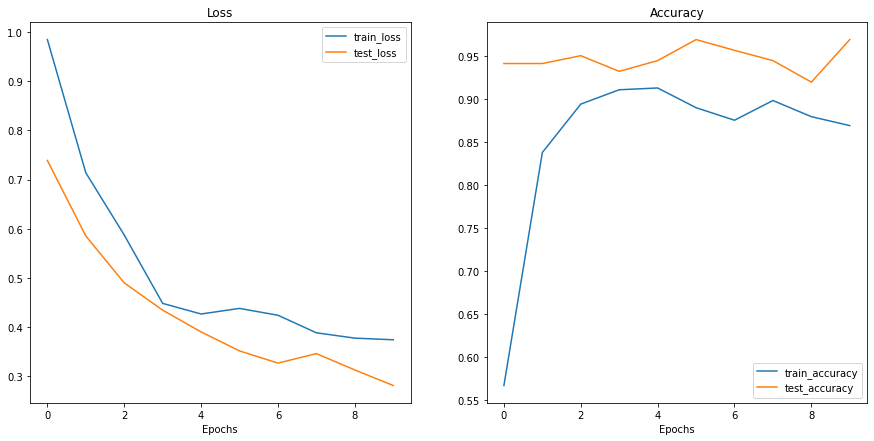

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [ ]:
from going_modular.going_modular import utils

# save the model
utils.save_model(model = effnetb2,
           target_dir="models",
           model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained EffnetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffnetB2 feature extractor model size: 29 MB


In [ ]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# create a dictionary with EffnetB2 statistics
effnetb2_stats = {"test_loss":effnetb2_results['test_loss'][-1],
                  "test_acc":effnetb2_results['test_acc'][-1],
                  "number_of_parameters":effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4. Create a ViT feature extractor

In [ ]:
# check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [ ]:
from torchinfo import summary

summary(vit,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# set up ViT dataloaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn = loss_fn,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


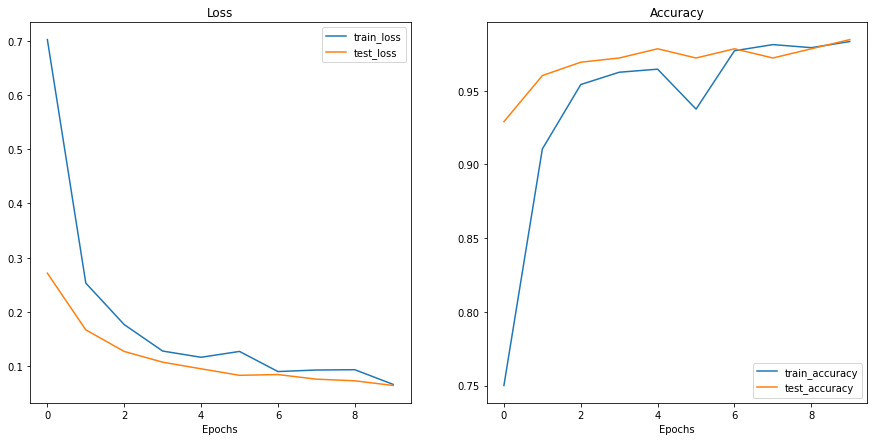

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [ ]:
# save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir='models',
                 model_name='09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [ ]:
from pathlib import Path

pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [ ]:
# count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# create ViT statistics dictionary
vit_stats = {"test_loss": vit_results['test_loss'][-1],
             "test_acc": vit_results['test_acc'][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [ ]:
from pathlib import Path

# get all the test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory {test_dir}")
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/670345.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3873655.jpg')]

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction probability and prediction tiime
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  pred_list = []

  # loop through target paths
  for path in tqdm(paths):

    # create empty dict to store prediction information
    pred_dict = {}

    # get the sample path and ground truth class name
    pred_dict['image_path'] = path
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # start the prediction timer
    start_time = timer()

    img = Image.open(path)

    # transform the image, add batch dimention to put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # prepare model for inference by sending it to the target device and turning on eval() mode
    model.to(device)
    model.eval()

    # get prediction probability, prediction label, and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) #turn logits into pred probability
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # make sure things in the dictionary are on the CPU (required for inspecting predictions)
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict['pred_class'] = pred_class

      end_time = timer()
      pred_dict['time_for_pred'] = round(end_time-start_time, 4)

    # does the pred match the true label?
    pred_dict['correct'] = class_name == pred_class

    # add the dictionary to the list of preds
    pred_list.append(pred_dict)

  return pred_list



          


In [ ]:
# make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                        model=effnetb2,
                                        transform=effnetb2_transforms,
                                        class_names=class_names,
                                        device='cpu') # make predictions on the cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# inspect the first two predictions
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9341,
  'pred_class': 'steak',
  'time_for_pred': 0.1908,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9268,
  'pred_class': 'steak',
  'time_for_pred': 0.1175,
  'correct': True}]

In [ ]:
# turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9341,steak,0.1908,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9268,steak,0.1175,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9524,steak,0.1423,True
3,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.6724,steak,0.1810,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9463,steak,0.2131,True


In [ ]:
# check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [ ]:
# find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time for prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time for prediction: 0.1825 seconds


In [ ]:
# add EffnetB2 average prediction time to stats dictionary
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28086441457271577,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1825}

In [ ]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                        model=vit,
                                        transform=vit_transforms,
                                        class_names=class_names,
                                        device='cpu') # make predictions on the cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9978,
  'pred_class': 'steak',
  'time_for_pred': 0.5555,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.522,
  'pred_class': 'steak',
  'time_for_pred': 0.4409,
  'correct': True}]

In [ ]:
import pandas as pd
vit_test_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9978,steak,0.5555,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5220,steak,0.4409,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9893,steak,0.4877,True
3,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.9986,steak,1.1411,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9957,steak,1.4024,True


In [ ]:
# count the number of correct predictions
vit_test_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [ ]:
#calculate the average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_df.time_for_pred.mean(),4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.6081 seconds


In [ ]:
# add average prediction time for the ViT model on CPU
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418211054988206,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.6081}

## 6. Comparing model results, prediction times and size

In [ ]:
df = pd.DataFrame([effnetb2_stats, vit_stats])

# add a column for model names
df['model'] = ['EffNetB2', 'ViT']

# convert accuracy to percentages
df['test_acc'] = round(df['test_acc']*100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29,0.1825,EffNetB2
1,0.064182,98.47,85800963,327,0.6081,ViT


In [ ]:
pd.DataFrame(data=(df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2']), # divide ViT stats by EffNetB2 stats
              columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228516,1.016412,11.135432,11.275862,3.332055


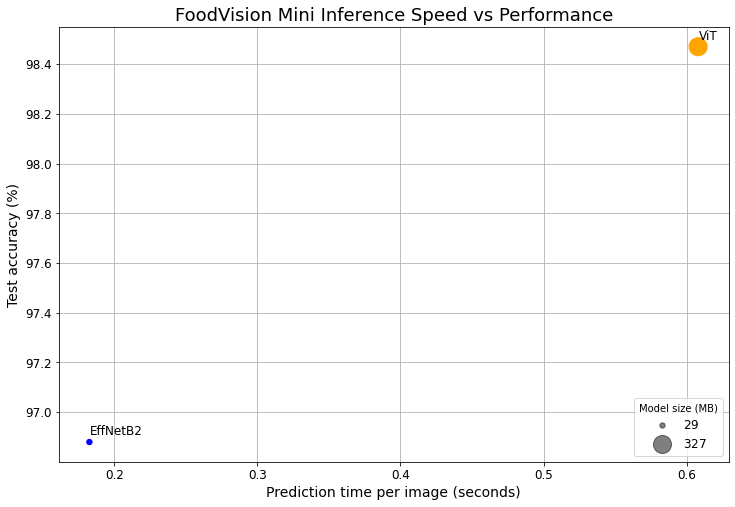

In [ ]:
# create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                     x='time_per_pred_cpu',
                     y='test_acc',
                     c=['blue','orange'],
                     s='model_size (MB)') # size of dots by the model size

# add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# annotate with model names
for index, row in df.iterrows():
  ax.annotate(text=row['model'], #note: depending on your version of matplotlib you may need to use s= instead of text=
              xy=(row['time_per_pred_cpu'] + 0.0006, row['test_acc']+0.03),
              size=12)

# create a legend based on model sizes
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc='lower right',
                              title='Model size (MB)',
                              fontsize=12)

# save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# show the figure
plt.show()

## Using Gradio

In [ ]:
#import/install gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version:{gr.__version__}")

Gradio version:3.20.1


In [ ]:
# put effnetb2 on CPU
effnetb2.to('cpu')

# check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  """ Transforms and performs a prediction on img and returns prediction and time taken
  """

  start_time = timer()

  # transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # pass the transformed image through the model and turn the prediction logits into pred probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)
  
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all the test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# predict on the target image and print out the results
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg

Prediction label and probability dictionary: 
{'pizza': 0.23839706182479858, 'steak': 0.24388399720191956, 'sushi': 0.5177189111709595}
Prediction time: 0.09974 seconds


In [ ]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/780283.jpg']]

In [ ]:
import gradio as gr

# create title, description and article strings
title = "FoodVision Mini"
description = "Using EffNetB2 feature extractor computer vision model to classify images for pizza, steak, or sushi"
article = ""

# create the gradio demo
demo = gr.Interface(fn=predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes=3, label="Predictions"),
                               gr.Number(label="Prediction time(s)")],
                    examples= example_list,
                    title = title,
                    description = description,
                    article = article)

# launch the demo
demo.launch(debug = False, # print errors locally?
            share = True) # generate a publically shareable URL?


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://24b191f9a92b6b1720.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


# Uploading to hugging spaces

In [ ]:
import shutil
from pathlib import Path

# create the foodvision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini")

# remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)
# check what's in the folder
!ls demos/foodvision_mini/


In [ ]:
import shutil
from pathlib import Path

# 1. create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. collect three random test datasets image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. copy the three random images to the examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name

  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)


[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os

# get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [ ]:
import shutil

# create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# try and move the file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  
  print("[INFO] Model move complete")
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps it's already moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")
  


[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete


In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch=1.12.0
torchvision=0.13.0
gradio=3.1.4

Writing demos/foodvision_mini/requirements.txt


In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


In [ ]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__" "*ipynb_checkpoints"

# download zip file
try:
  from google.colab import files
  files.download('demos/foodvision_mini.zip')
except:
  print("Failed google.colab.download")

updating: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: app.py (deflated 57%)
updating: examples/ (stored 0%)
updating: examples/2582289.jpg (deflated 17%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/592799.jpg (deflated 1%)
updating: model.py (deflated 56%)
updating: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# embed Foodvision Mini Gradio Demo
IFrame(src="https://huggingface.co/spaces/hulkster/my_foodvision_mini/+", width=900, height=750)